In [13]:
import torch
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt

from src import *

external_path=''

In [14]:
model=CNN()
model.load_state_dict(torch.load('cnn_mnist.pth'))
model.eval()

CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=64, bias=True)
  )
  (out_layer): Linear(in_features=64, out_features=10, bias=True)
)

In [34]:
def logit_influence_on_target_class(positive_digit,negative_digit,concept_vector_type='cav',epsilon=1e-3):
    latent_activations=torch.load(f'{external_path}\\latent_activations\\{positive_digit}.pt')
    if concept_vector_type=='cav':
        concept_vector=torch.load(f'{external_path}\\concept_activation_vectors\\{positive_digit}_{negative_digit}.pt')
    elif concept_vector_type=='cbv':
        concept_vector=torch.tensor(np.load(f'{external_path}\\concept_boundary_vectors\\{positive_digit}_{negative_digit}.npy'))
    else:
        raise ValueError('Enter valid concept vector type, cav,cbv')

    grads=[]
    for k in range(latent_activations.shape[0]):
        logit_grads=(model.out_layer(latent_activations[k,:]+epsilon*concept_vector)-model.out_layer(latent_activations[k,:]))/epsilon
        grads.append(logit_grads[positive_digit].item())
    grads=np.array(grads)
    np.save(f'{external_path}\\cluster_info\\gradients_on_target_{concept_vector_type}\\{positive_digit}_{negative_digit}.npy',grads)
    return grads

In [35]:
def logit_influence_on_source_class(positive_digit,negative_digit,concept_vector_type='cav',epsilon=1e-3):
    latent_activations=torch.load(f'{external_path}\\latent_activations\\{positive_digit}.pt')
    if concept_vector_type=='cav':
        concept_vector=torch.load(f'{external_path}\\concept_activation_vectors\\{positive_digit}_{negative_digit}.pt')
    elif concept_vector_type=='cbv':
        concept_vector=torch.tensor(np.load(f'{external_path}\\concept_boundary_vectors\\{positive_digit}_{negative_digit}.npy'))
    else:
        raise ValueError('Enter valid concept vector type, cav,cbv')

    grads=[]
    for k in range(latent_activations.shape[0]):
        logit_grads=(model.out_layer(latent_activations[k,:]+epsilon*concept_vector)-model.out_layer(latent_activations[k,:]))/epsilon
        grads.append(logit_grads[negative_digit].item())
    grads=np.array(grads)
    np.save(f'{external_path}\\cluster_info\\gradients_on_source_{concept_vector_type}\\{positive_digit}_{negative_digit}.npy',grads)
    return grads

In [36]:
cav_mean_grads_on_target=[]
cbv_mean_grads_on_target=[]
cav_mean_grads_on_source=[]
cbv_mean_grads_on_source=[]

for positive_digit in range(10):
    for negative_digit in range(10):
        if positive_digit==negative_digit:
            continue
        cav_grads_on_target=logit_influence_on_target_class(positive_digit,negative_digit,concept_vector_type='cav')
        cbv_grads_on_target=logit_influence_on_target_class(positive_digit,negative_digit,concept_vector_type='cbv')
        cav_mean_grads_on_target.append(sum(cav_grads_on_target)/len(cav_grads_on_target))
        cbv_mean_grads_on_target.append(sum(cbv_grads_on_target)/len(cbv_grads_on_target))

        cav_grads_on_source=logit_influence_on_source_class(positive_digit,negative_digit,concept_vector_type='cav')
        cbv_grads_on_source=logit_influence_on_source_class(positive_digit,negative_digit,concept_vector_type='cbv')
        cav_mean_grads_on_source.append(sum(cav_grads_on_source)/len(cav_grads_on_source))
        cbv_mean_grads_on_source.append(sum(cbv_grads_on_source)/len(cbv_grads_on_source))

Text(0, 0.5, 'CBV Logit Influence')

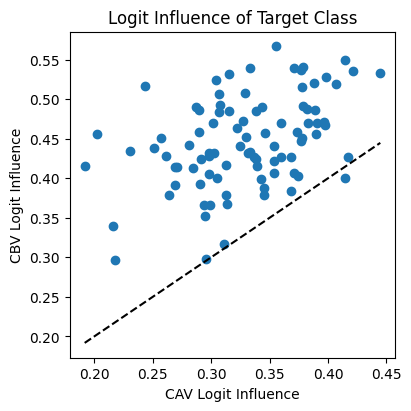

In [24]:
fig,axs=plt.subplots(nrows=1,ncols=1,layout='constrained')
fig.set_figwidth(4)
fig.set_figheight(4)

axs.scatter(cav_mean_grads_on_target,cbv_mean_grads_on_target)
axs.plot([min(cav_mean_grads_on_target),max(cav_mean_grads_on_target)],[min(cav_mean_grads_on_target),max(cav_mean_grads_on_target)],color='black',linestyle='--')
axs.set_title('Logit Influence of Target Class')
axs.set_xlabel('CAV Logit Influence')
axs.set_ylabel('CBV Logit Influence')

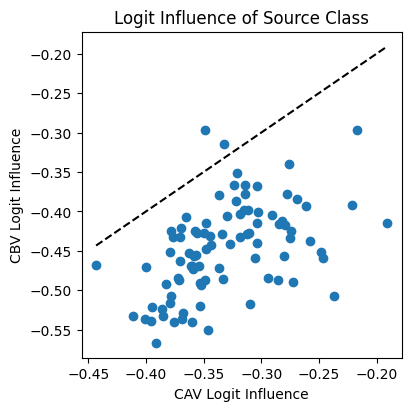

In [25]:
fig,axs=plt.subplots(nrows=1,ncols=1,layout='constrained')
fig.set_figwidth(4)
fig.set_figheight(4)

axs.scatter(cav_mean_grads_on_source,cbv_mean_grads_on_source)
axs.plot([min(cav_mean_grads_on_source),max(cav_mean_grads_on_source)],[min(cav_mean_grads_on_source),max(cav_mean_grads_on_source)],color='black',linestyle='--')
axs.set_title('Logit Influence of Source Class')
axs.set_xlabel('CAV Logit Influence')
axs.set_ylabel('CBV Logit Influence')
plt.show()